# Обробка сигналів - лабораторна робота 1
Виконав: Басистий Олег

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
import IPython.display as ipd
import os 
from scipy.io import loadmat
from scipy.signal import resample

## Завдання 0. Тривалість дискретних сигналів

Для того, щоб отримати довжину сигналу -- поділимо довжину масиву (без одиниць) - на частоту (1/c). Отримаємо величину - в секундах.

In [4]:
def signal_len(signal, freq):
    return len(signal) / freq

## Завдання 1. Запис сигналів з внутрішніх датчиків

Записи IMU можна знайти в `data/imu`

In [69]:
imu_fs = 100

standing_gyro = pd.read_csv("data/imu/gyro_standing.csv")
standing_accel = pd.read_csv("data/imu/acc_standing.csv")

walking_gyro = pd.read_csv("data/imu/gyro_walking.csv")
walking_accel = pd.read_csv("data/imu/acc_walking.csv")

running_gyro = pd.read_csv("data/imu/gyro_running.csv")
running_accel = pd.read_csv("data/imu/acc_running.csv")

Визначимо функцію, яка відразу будуватиме графіки як для гіроскопу, так і для акселерометру, по усіх вісях.

In [75]:
def plot_gyro_acc(gyro_df, acc_df, fs):
    gyro_time = gyro_df.index / fs if fs else gyro_df["time"]
    acc_time  = acc_df.index / fs if fs else acc_df["time"]

    fig, axs = plt.subplots(2, 1, figsize=(20, 8))

    axs[0].plot(gyro_time, gyro_df["wx"], label="wx")
    axs[0].plot(gyro_time, gyro_df["wy"], label="wy")
    axs[0].plot(gyro_time, gyro_df["wz"], label="wz")
    axs[0].set_title("Gyroscope")
    axs[0].set_ylabel("rad/s")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_xlim(left=gyro_time.min(), right=gyro_time.max())

    axs[1].plot(acc_time, acc_df["ax"], label="ax")
    axs[1].plot(acc_time, acc_df["ay"], label="ay")
    axs[1].plot(acc_time, acc_df["az"], label="az")
    axs[1].plot(acc_time, acc_df["atotal"], label="a total", linestyle="--")
    axs[1].set_title("Accelerometer")
    axs[1].set_ylabel("m/s²")
    axs[1].set_xlabel("Time (s)" if fs else "Timestamp")
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_xlim(left=acc_time.min(), right=acc_time.max())

    plt.tight_layout()
    plt.show()

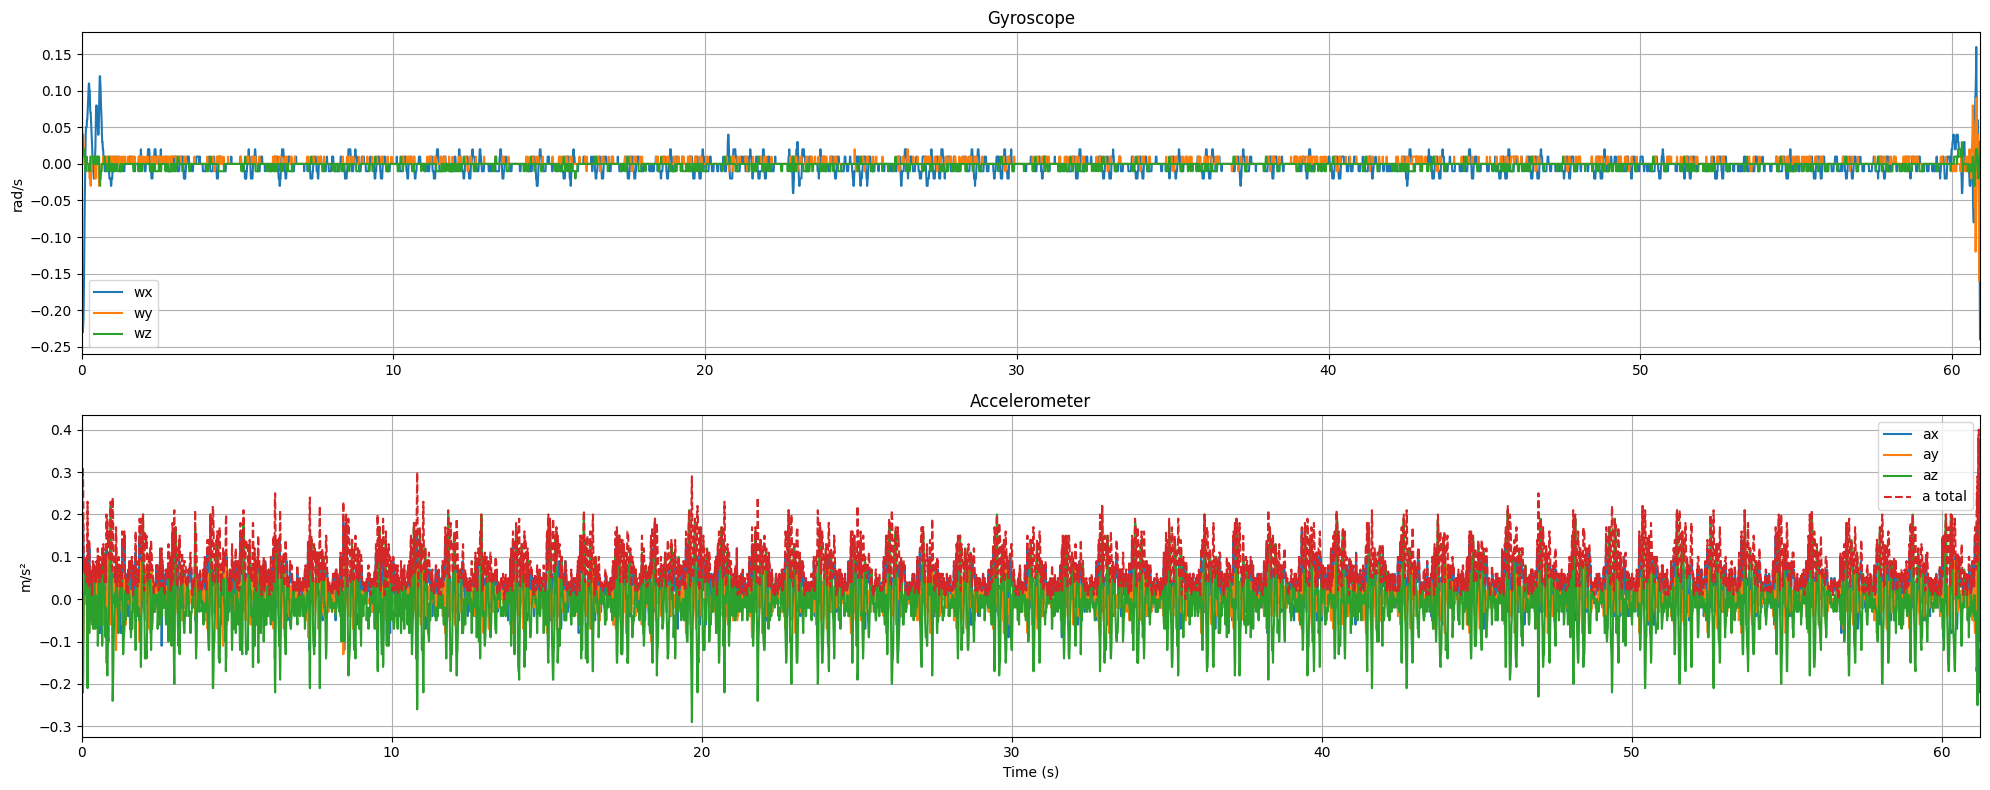

In [76]:
plot_gyro_acc(standing_gyro, standing_accel, imu_fs)

Можна побачити, що значення сильно не змінюються, а тільки дрейфують навколо 0.

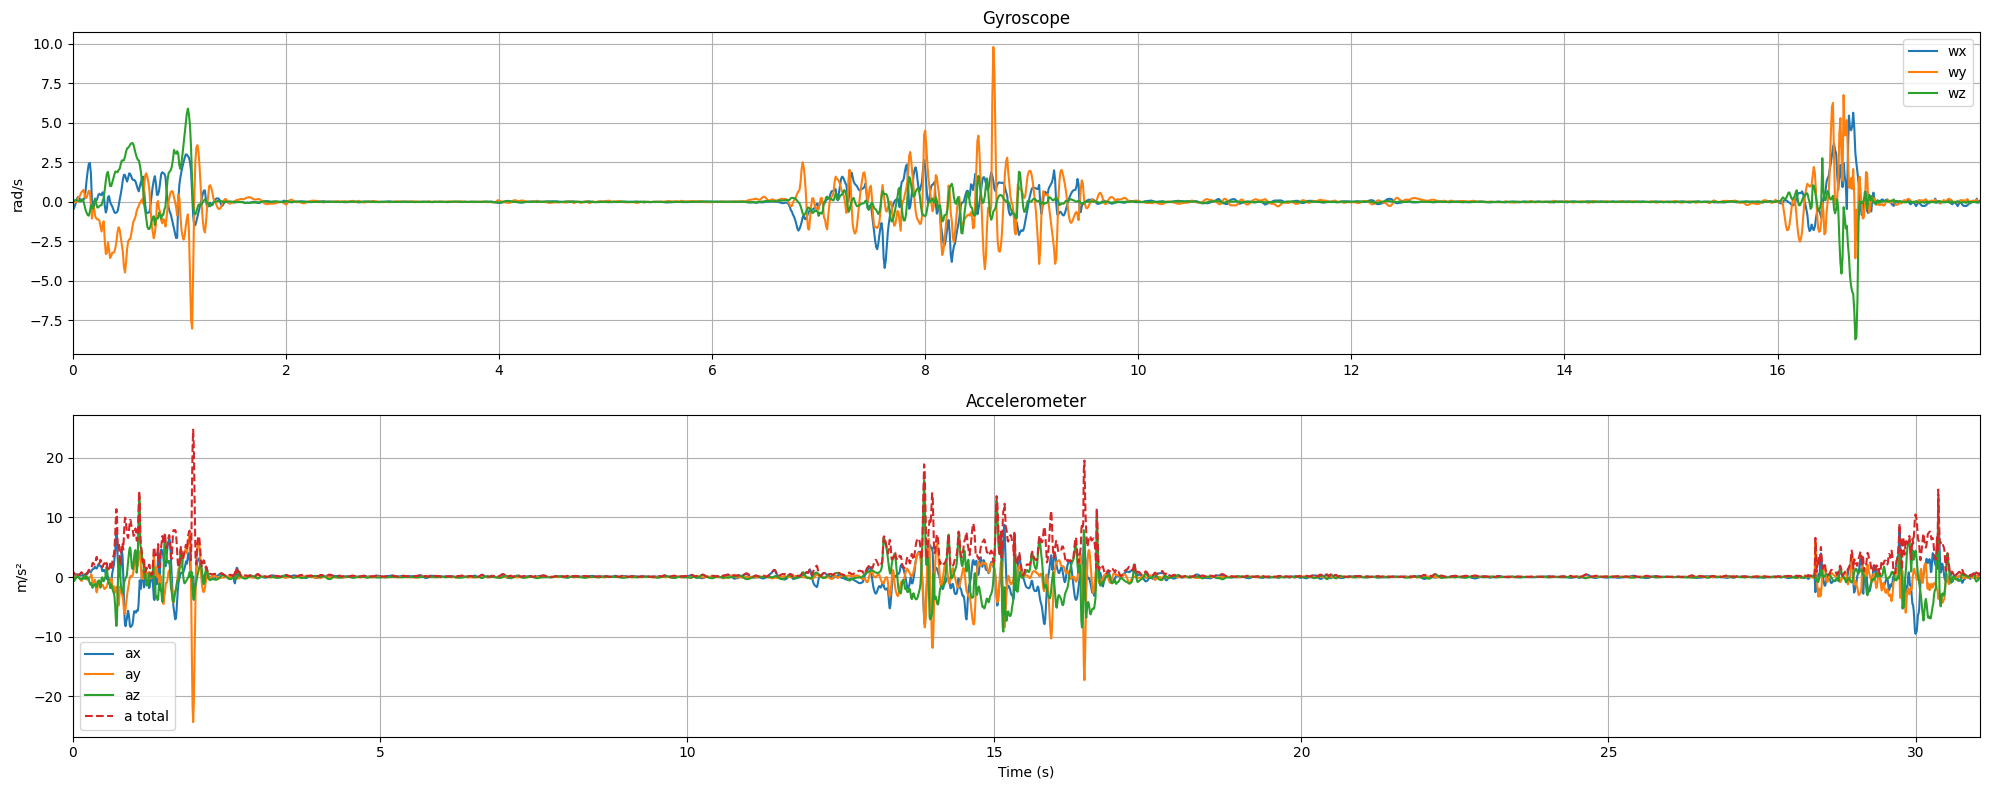

In [77]:
plot_gyro_acc(walking_gyro, walking_accel, imu_fs)

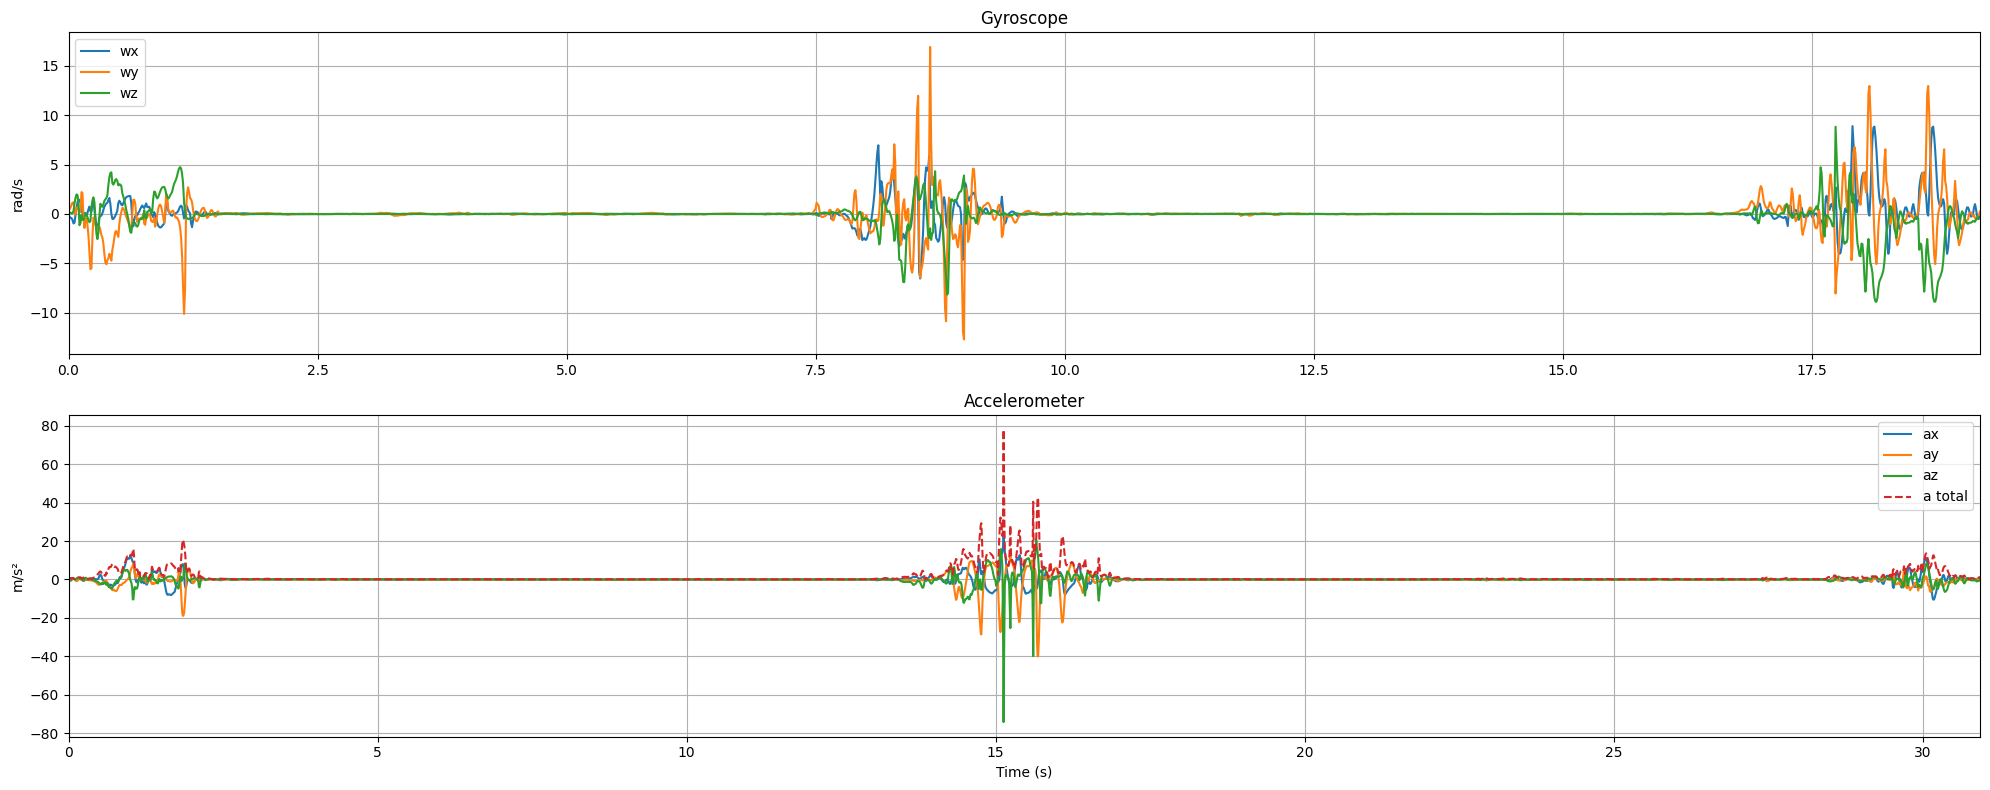

In [78]:
plot_gyro_acc(running_gyro, running_accel, imu_fs)

Для бігу та ходьби, можна виокремлити періоди коли людина була в русі, а коли стояла. Якщо порівняти графіки ходьби та бігу, можна побачити, що ходьба має меншу амплітуду, проте на довший час, коли біг - навпаки.

## Завдання 2. Запис звуку з пристрою

Я вирішив використати одну відому пісню, яку додав до папки з даними.

In [27]:
data, sr = sf.read("data/music/cool_song.mp3")
duration = 5
print(sr)

44100


In [28]:
num_samples = int(duration * sr)
data_44khz = data[:num_samples]

In [29]:
target_sr = 8000
n = int(duration * target_sr)
data_8khz = resample(data_44khz, n)

In [30]:
os.makedirs("output", exist_ok=True)
sf.write("output/cool_song_8khz.wav", data_8khz, target_sr)
sf.write("output/cool_song_44khz.wav", data_44khz, sr)

In [31]:
Audio_8k = ipd.Audio("output/cool_song_8khz.wav", autoplay=True)

In [32]:
Audio_44k = ipd.Audio("output/cool_song_44khz.wav", autoplay=True)

Прослухавши обидва файли, можна легко почути, як сильно деградувала якість звуку в порівнянні з файлом з частотою дискретизації 44кГц.

In [33]:
def plot_signal(signal, s_rate, title = 'EEG Signal', offset=0, ylabel="Amplitude, muV"):
    time = np.arange(offset, offset + signal_len(signal, s_rate), 1/s_rate)
    plt.figure(figsize=(12, 4))
    plt.plot([0] * len(time), color='black', linestyle='--', linewidth=0.8)
    plt.plot(time, signal, color='lightcoral')
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(left=offset, right=time[-1])
    plt.tight_layout()
    plt.show()

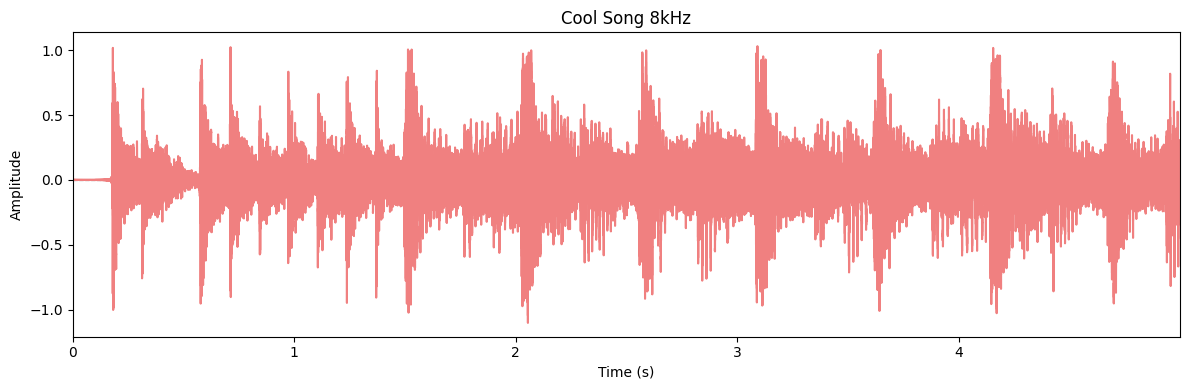

In [34]:
plot_signal(data_8khz, target_sr, title="Cool Song 8kHz", ylabel="Amplitude")

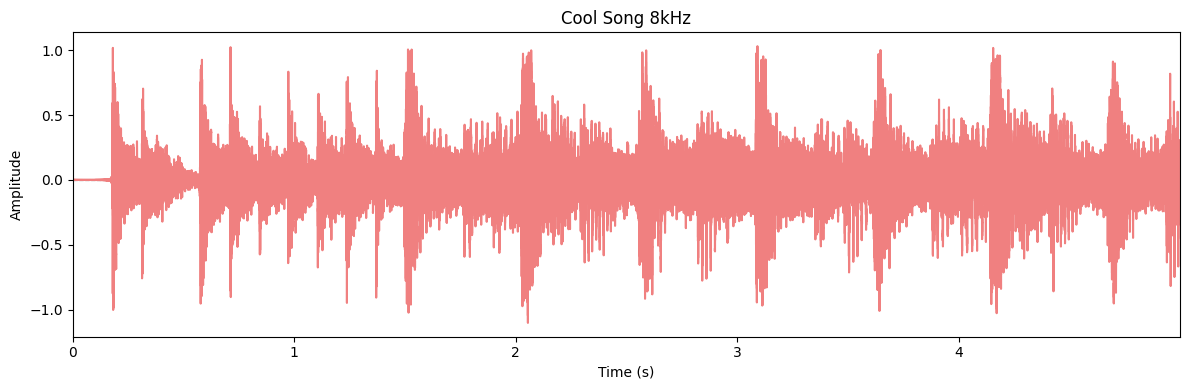

In [35]:
plot_signal(data_8khz, target_sr, title="Cool Song 8kHz", ylabel="Amplitude")

Можна побачити, що більший sampling rate результує в більш гладкому графіку.

## Завдання 3. Зчитання даних з ЕЕГ

Зчитаємо EEG дані з запропонованих файлів. Для цього, визначимо функцію-завгортку навколо методу `loadmat` з бібліотеки `scipy`, що читає MATLAB файли. Замість словника - повертається numpy список time-series сигналу.

In [37]:
def load_mat_signal(file_path):
    return np.array(loadmat(file_path)['sig'][0])

Частота дискретизації вхідних EEG даних - 256 Гц.

In [38]:
healthy = load_mat_signal('data/eeg/eeg_healthy_1.mat')
sick = load_mat_signal('data/eeg/eeg_sick_1.mat')
sample_rate = 256

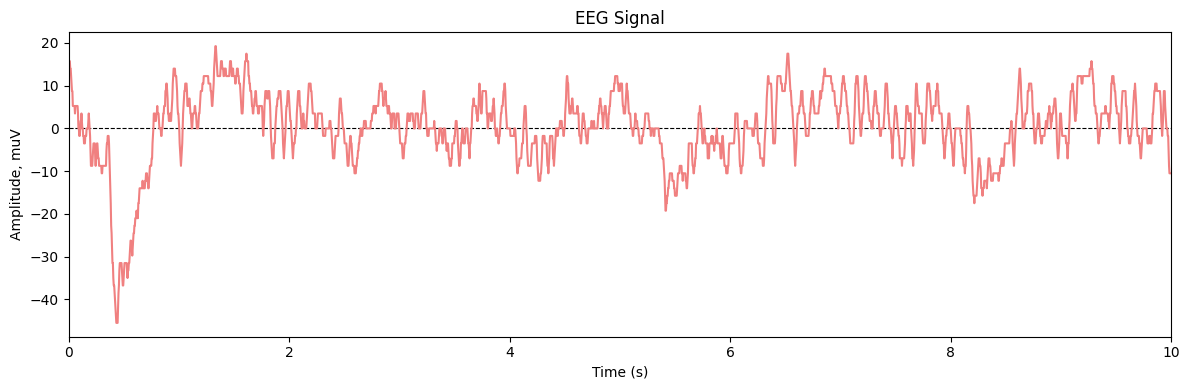

In [39]:
plot_signal(healthy, sample_rate)

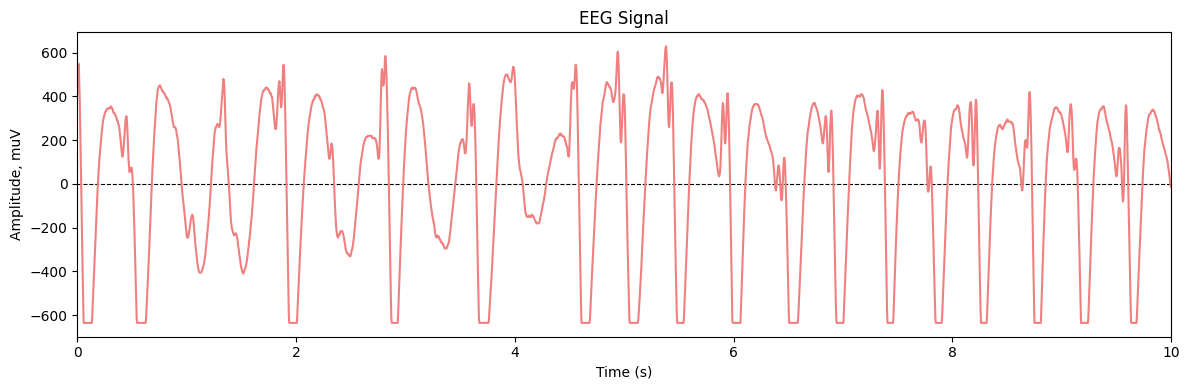

In [40]:
plot_signal(sick, sample_rate)

## Завдання 4. Функція для виводу ділянки сигналів

Задля візуалізації, можна скористатися функцією, визначеною раніше для EEG. 

Функція викличе помилку за наступних умов:
* якщо початковий час більший за кінцевий
* якщо початковий або кінцевий час від'ємний (окрім випадку де end_time = -1, приймаємо це як останній time stamp задля зручності)
* якщо кінцевий час більший за кінецвий час сигналу  

Наявні аргументи додаткові аргументи `title` - "назва" для графіку, та `return_signal` - флажок, чи слід повертати оновлений часовий ряд.

In [41]:
def plot_signal_parted(signal, s_rate, start = 0, end = -1, title = 'EEG Signal', return_signal = False, ylabel="Amplitude, muV"):
    if start < 0 or (end != -1 and end < 0) or (end != -1 and end <= start) \
     or end > signal_len(signal, s_rate):
        raise ValueError("Invalid start or end time.")
    start_idx = int(start * s_rate)
    end_idx = int(end * s_rate) if end != -1 else len(signal)
    signal = signal[start_idx:end_idx]
    plot_signal(signal, s_rate, title=title, offset=start, ylabel=ylabel)
    if return_signal:
        return signal


Перевіримо функцію на даних з попередніх завдань

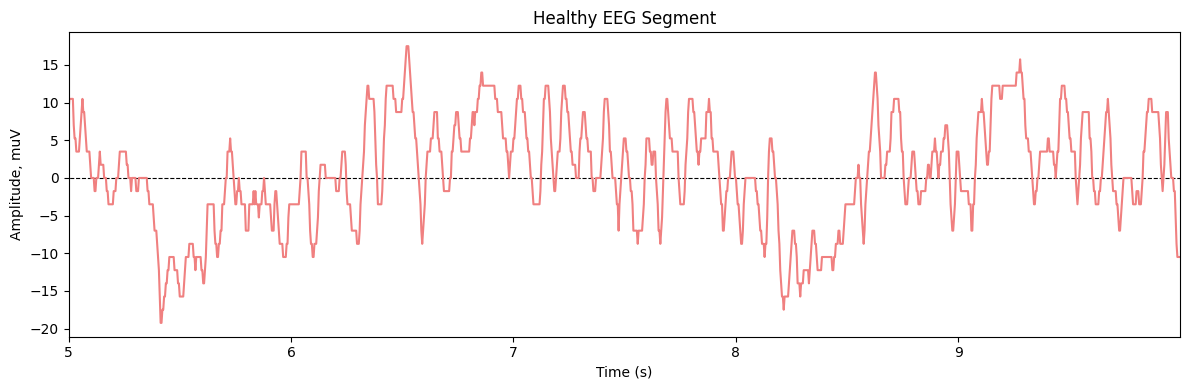

Validation check
   length match: True
   items match:  True



In [42]:
half_healthy = plot_signal_parted(healthy, sample_rate, start=5, end=10, title='Healthy EEG Segment', return_signal=True)
print(f"""Validation check
   length match: {len(half_healthy) == 5 * sample_rate}
   items match:  {all(half_healthy == healthy[5 * sample_rate:10 * sample_rate])}
""")

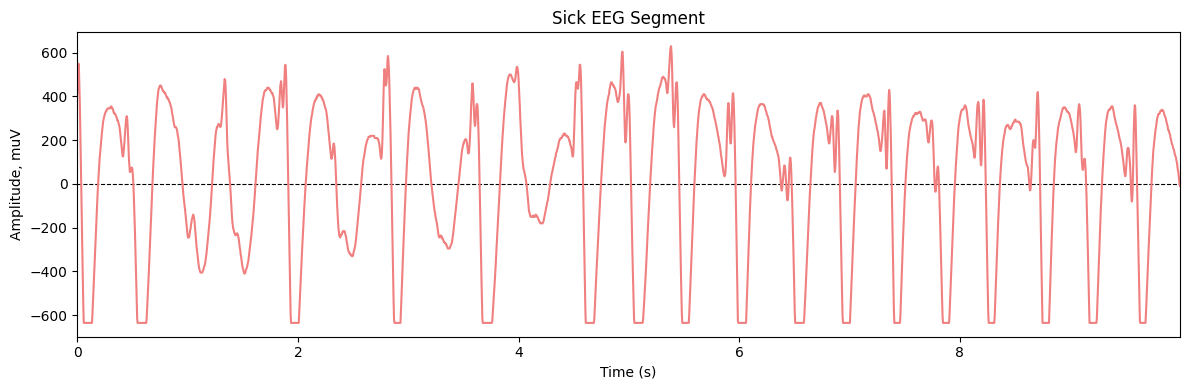

Validation check
   length match: True
   items match:  True


In [43]:
one_third_sick = plot_signal_parted(sick, sample_rate, start=0, end=10, title='Sick EEG Segment', return_signal=True)
print(f"""Validation check
   length match: {len(one_third_sick) == 10 * sample_rate}
   items match:  {all(one_third_sick == sick[:10 * sample_rate])}""")

Також, візуалізуємо сигнали з попередніх завдань

### Сигнали з завдання 1

Оскільки, даних дуже багато, виведемо Х-координати для акселерометрів кожного з сигналів.

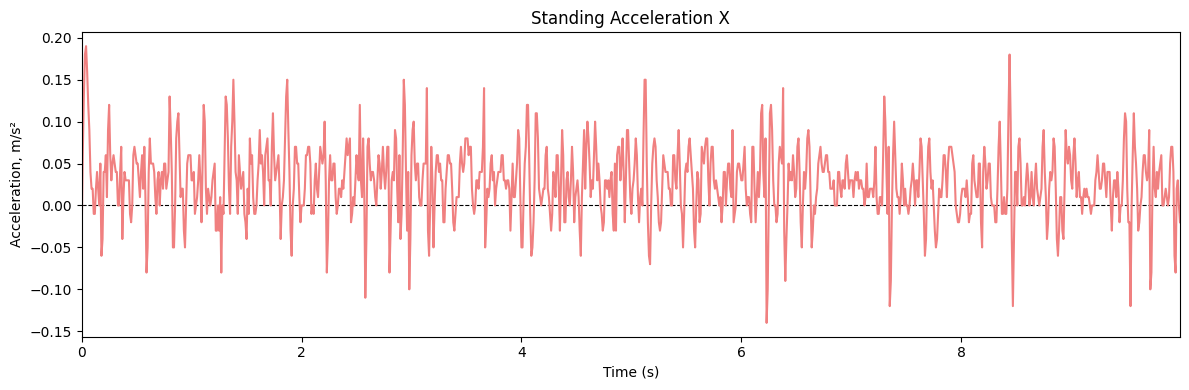

In [82]:
plot_signal_parted(standing_accel['ax'], imu_fs, start=0, end=10, title='Standing Acceleration X', ylabel="Acceleration, m/s²")

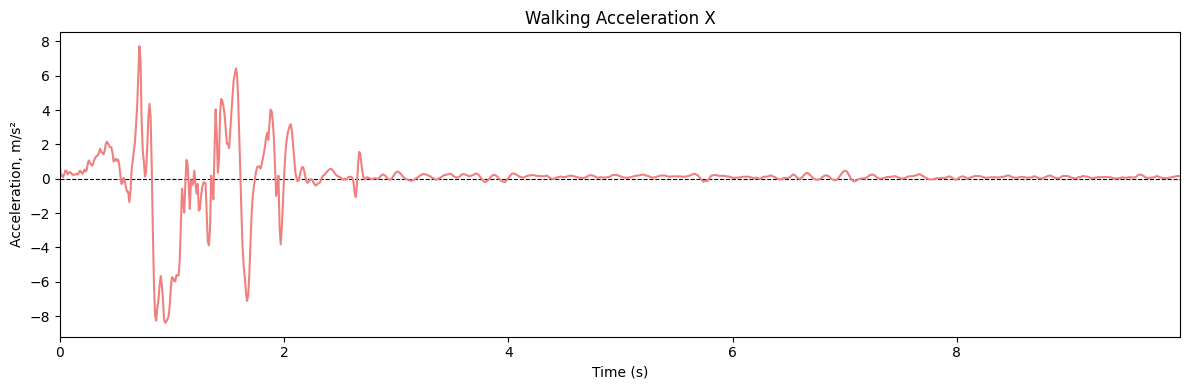

In [83]:
plot_signal_parted(walking_accel['ax'], imu_fs, start=0, end=10, title='Walking Acceleration X', ylabel="Acceleration, m/s²")

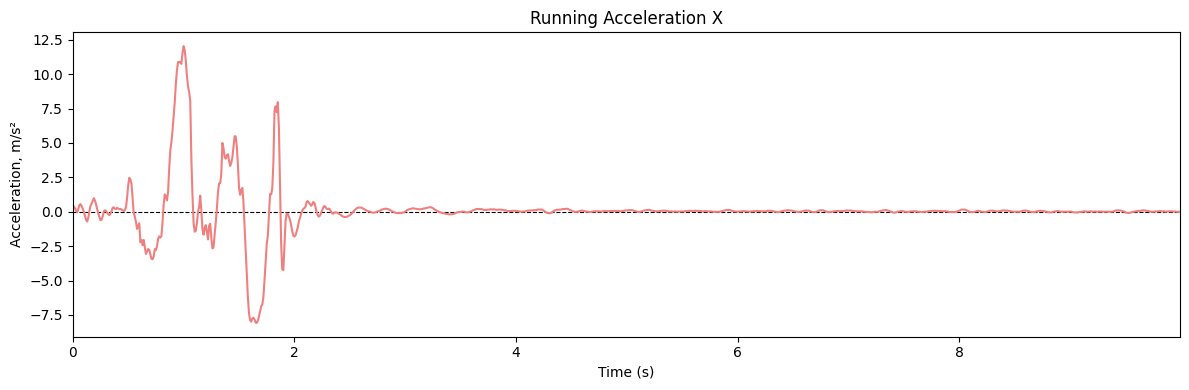

In [84]:
plot_signal_parted(running_accel['ax'], imu_fs, start=0, end=10, title='Running Acceleration X', ylabel="Acceleration, m/s²")

Можна побачити більш стрімкий рух на графіку з бігом, і більш ранній стоп в порівнянні з графіком, де була ходьба.

### Сигнали з завдання 2

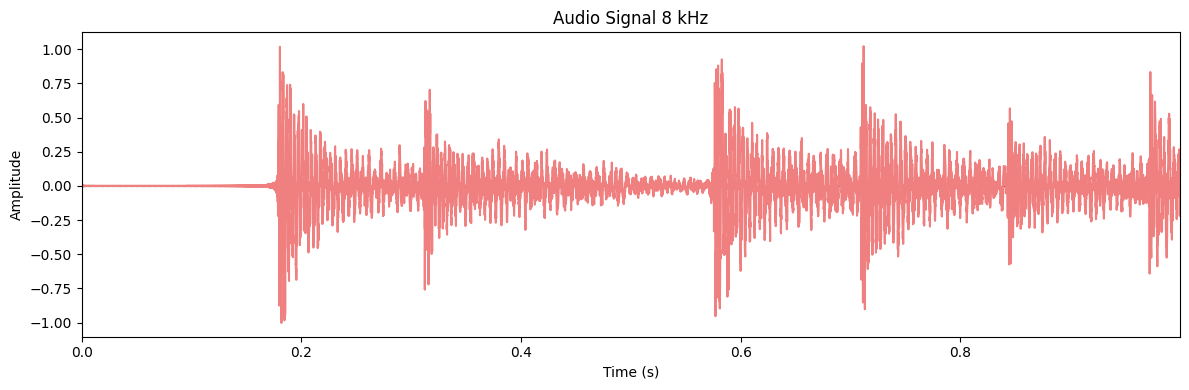

In [49]:
plot_signal_parted(data_8khz, 8000, title='Audio Signal 8 kHz', ylabel="Amplitude", start=0, end=1)

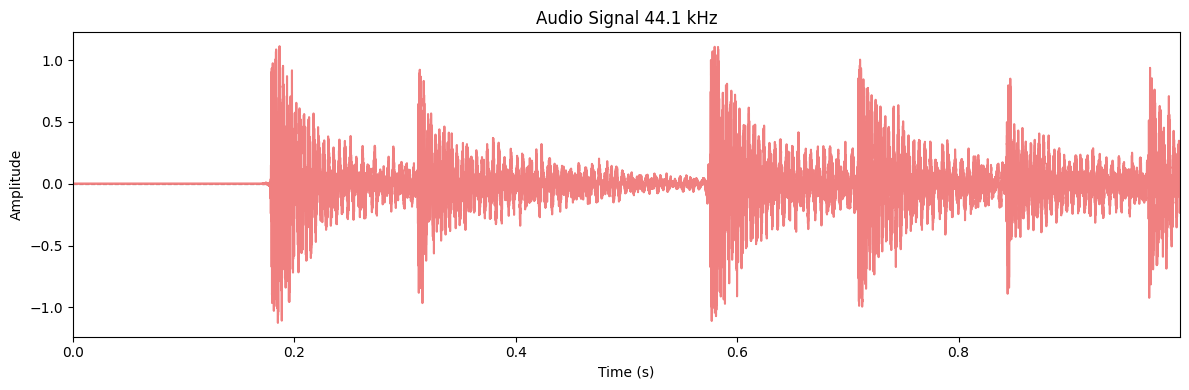

In [50]:
plot_signal_parted(data_44khz, 44100, title='Audio Signal 44.1 kHz', ylabel="Amplitude", start=0, end=1)

Можна побачити, що більший sampling rate результує в більш гладкому графіку.

## Завдання 5. Візуалізація EСG сигналів

In [51]:
def read_ecg_signal(file_path):
    return np.load(file_path)

In [52]:
norm = read_ecg_signal('data/ecg/ecg_norm.npz')
anomaly = read_ecg_signal('data/ecg/ecg_anomaly.npz')

In [53]:
def get_ecg_info(ecg_signal):
    print(f"Keys: {ecg_signal.files}")
    for key in ecg_signal.files:
        print(f"{key}: {ecg_signal[key]}")

Передивимося структуру даних з ЕКГ, щоб було зрозуміло, з чим ми працюємо.

In [54]:
get_ecg_info(norm)
print("="*100)
get_ecg_info(anomaly)

Keys: ['description', 'source', 'fs', 'units', 'signal', 'labels', 'labels_indexes', 'source_start', 'source_end']
description: 
source: mitdb/100
fs: 250
units: mV
signal: [-0.07272279 -0.06141497 -0.08927172 ... -0.25111498 -0.26430862
 -0.25950177]
labels: ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
labels_indexes: [  15  215  424  631  838 1040 1238 1433 1635 1845 2054 2261 2463 2657
 2856]
source_start: 10000
source_end: 13000
Keys: ['description', 'source', 'fs', 'units', 'signal', 'labels', 'labels_indexes', 'source_start', 'source_end']
description: Patient with paced beats(using pacemaker device)
source: mitdb/107
fs: 250
units: mV
signal: [0.18942029 0.19776157 0.20501576 ... 0.09178647 0.0801407  0.07180146]
labels: ['/' '/' '/' '/' '/' '/' '/' '/' '/' '/' '/' '/']
labels_indexes: [  34  253  473  690  894 1097 1310 1527 1745 1963 2177 2386]
source_start: 11000
source_end: 13500


Оскільки окрім самого сигналу - слід наносити биття серця, потрібно визначити окрему функцію для ECG.

In [55]:
def plot_ecg(ecg_signal):
    sample_rate = ecg_signal['fs']
    signal = ecg_signal['signal']
    label_idx = ecg_signal['labels_indexes']
    time = np.arange(0, signal_len(signal, sample_rate), 1/sample_rate)
    plt.figure(figsize=(20, 7))
    plt.plot(time, signal, color='lightcoral')
    for idx in label_idx:
        plt.scatter(idx / sample_rate, signal[idx], color='skyblue', s=50, label="Heart beat" if idx == label_idx[0] else "")
    plt.xlim(left=0, right=time[-1])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude, mV')
    plt.legend()
    plt.show()

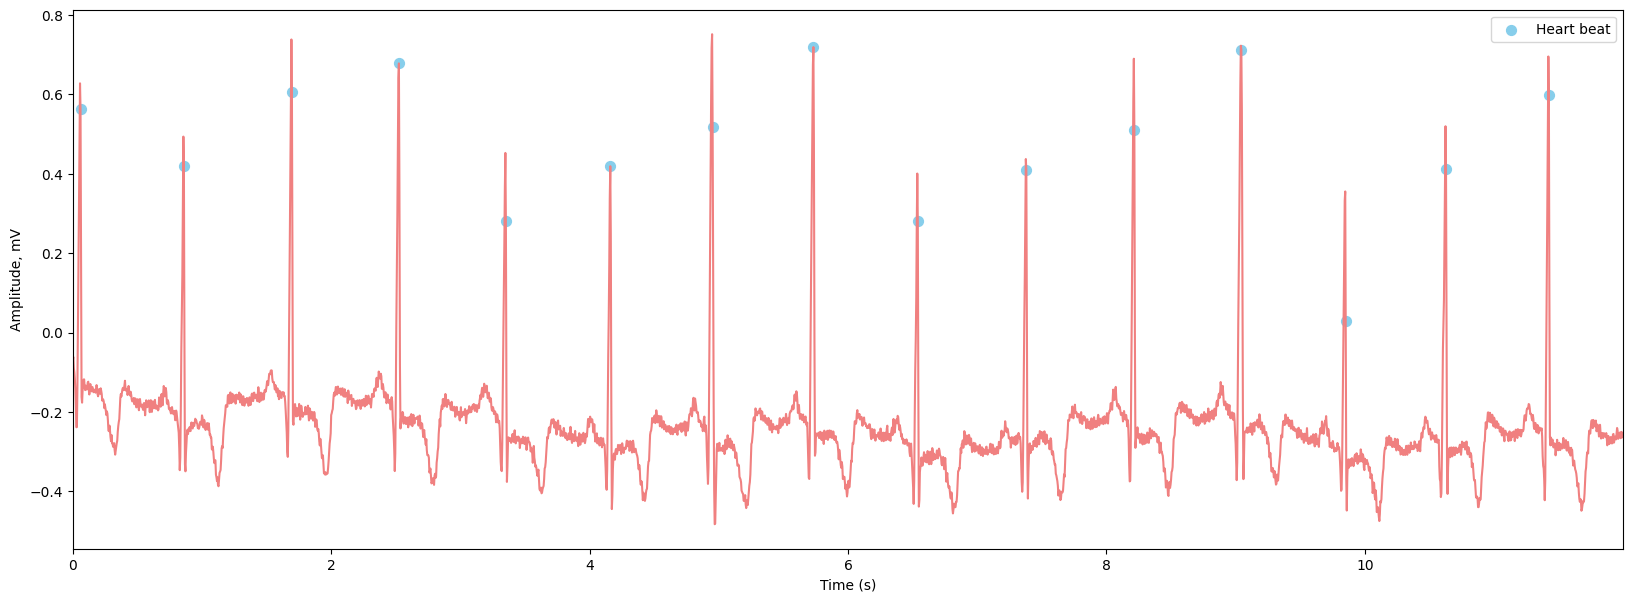

In [56]:
plot_ecg(norm)

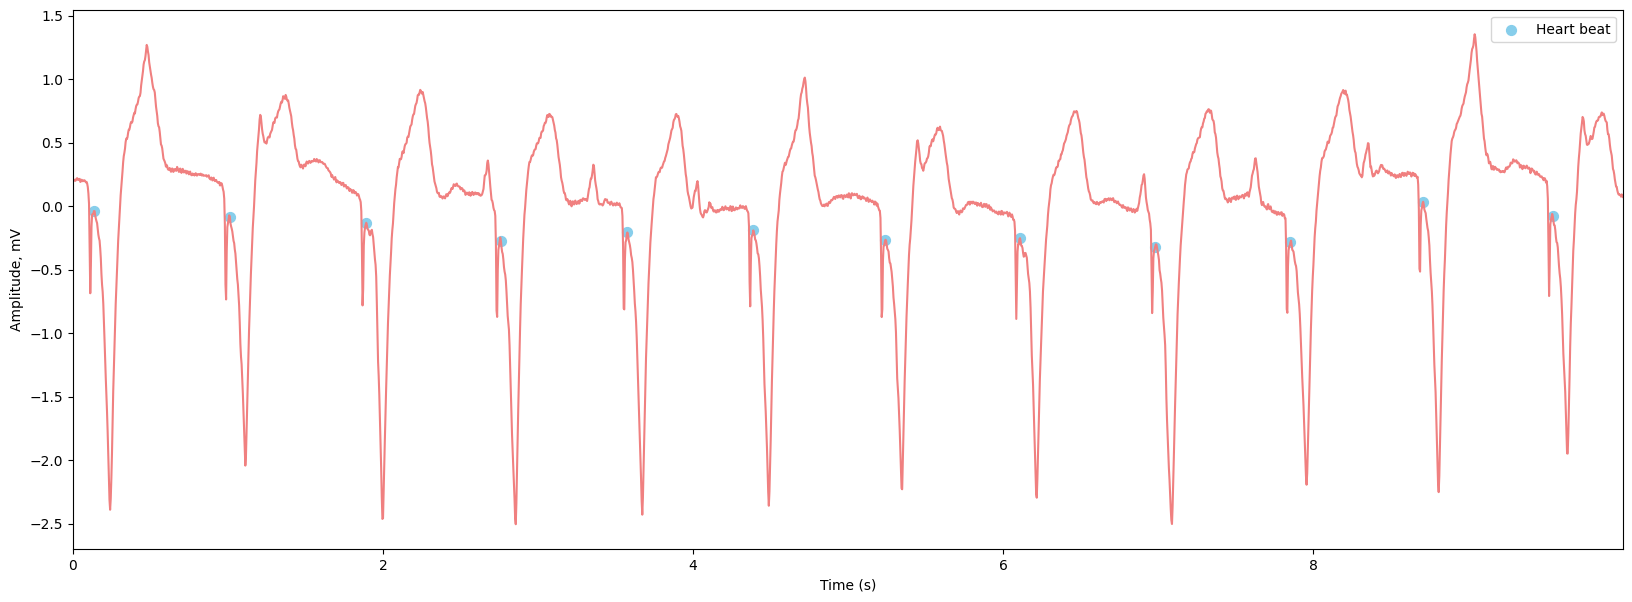

In [57]:
plot_ecg(anomaly)